# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Metrics

In [56]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql.types import IntegerType, StringType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier , DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [45]:
spark = SparkSession.builder \
    .appName("PySparkSetup") \
    .config("spark.pyspark.python", "c:\\Users\\moz95\\AppData\\Local\\Programs\\Python\\Python313\\python.exe") \
    .config("spark.pyspark.driver.python", "c:\\Users\\moz95\\AppData\\Local\\Programs\\Python\\Python313\\python.exe") \
    .getOrCreate()

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .appName("Sparkify Project") \
    .getOrCreate()

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Sparkify") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql_2.12:3.1.2") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.network.timeout", "800s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()

In [5]:
spark = SparkSession.builder \
    .appName("Sparkify") \
    .master("local[*]") \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
# Load the dataset into a Spark DataFrame
df = spark.read.json("mini_sparkify_event_data.json")

In [7]:
# Display schema of the DataFrame
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df.count()

286500

In [9]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [10]:
# Clean the empty userId

df = df.filter(df.userId!="")
df.count()

278154


Upon initially loading the dataset, I observed that it contains 286,500 log entries spanning 18 unique columns. These entries represent individual transactions rather than unique users (GET USER COUNT HERE). Below is a breakdown of the dataset's columns:

- Artist: The artist being listened to
- Auth: Indicates whether the user is logged in
- FirstName: The user's first name
- Gender: The user's gender
- ItemInSession: The item number within a session
- LastName: The user's last name
- Length: Duration of a specific log entry
- Level: Specifies if the user has a free or paid account
- Location: The user's physical location
- Method: Type of web request (e.g., GET, PUT)
- Page: The webpage the user is currently on
- Registration: The user's registration number
- SessionId: Identifier for the user's session
- Song: The song being played
- Status: HTTP status code (e.g., 200 for OK)
- Ts: Timestamp of the current log
- UserAgent: The browser or device used by the user
- UserId: The user's unique identifier

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
# See Different Pages

df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



One column of particular importance is the "Page" column, which provides insight into the specific pages users are interacting with on the platform.
The possible values in the "Page" column are as follows:

- Add Friend
- Add to Playlist
- Cancel
- Cancellation Confirmation
- Downgrade
- Error
- Help
- Home
- Logout
- NextSong
- Roll Advert
- Save Settings
- Settings

The pages we never want to see users utilize is the “Cancel” and especially the “Cancellation Confirmation”.

In [12]:
df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(20)

+------+
|userId|
+------+
|    18|
|    32|
|   125|
|    51|
|   101|
|    87|
|    17|
|   122|
|   143|
|   105|
|   121|
|    12|
|   129|
|    73|
|     3|
|    58|
|    28|
|   103|
|   106|
|    54|
+------+
only showing top 20 rows



In [13]:
df.select(["userId", "page", "ts", "level", "song", "sessionId"]).where(df.userId == "123").sort("ts").show(100)

+------+---------------+-------------+-----+--------------------+---------+
|userId|           page|           ts|level|                song|sessionId|
+------+---------------+-------------+-----+--------------------+---------+
|   123|       NextSong|1540578325000| free|          Hammerhart|      243|
|   123|    Roll Advert|1540578372000| free|                NULL|      243|
|   123|       NextSong|1540578528000| free|         Kennedy Rag|      243|
|   123|         Logout|1540578529000| free|                NULL|      243|
|   123|           Home|1540578601000| free|                NULL|      243|
|   123|       NextSong|1540578684000| free|   The Sun Also Sets|      243|
|   123|Add to Playlist|1540578731000| free|                NULL|      243|
|   123|       NextSong|1540578933000| free|      The Golden Age|      243|
|   123|       NextSong|1540579163000| free|             Pimp On|      243|
|   123|       NextSong|1540579446000| free|        Hero/Heroine|      243|
|   123|    

Observations:

1- Page Activity:

- The user interacts with various pages such as NextSong, Add to Playlist, Logout, and Home.
  Significant time is spent playing songs (NextSong events).

2- Subscription Level:

- The user is on a free subscription plan.

3- Session Distribution:

- All activities are associated with sessionId = 243, except for the last entry (sessionId = 1550), indicating separate listening sessions.
  Songs Played:

4- Songs like "Hammerhart", "Catch You Baby", and "Hollywood" were played.

In [14]:
# Summarize the user's activity by page type:

df.filter(df.userId == "123").groupBy("page").count().show()

+---------------+-----+
|           page|count|
+---------------+-----+
|           Home|    6|
|    Roll Advert|   14|
|         Logout|    4|
|Add to Playlist|    8|
|       NextSong|  150|
|    Thumbs Down|    1|
|       Settings|    1|
|     Add Friend|    5|
|      Thumbs Up|    5|
|           Help|    1|
|        Upgrade|    1|
+---------------+-----+



In [15]:
# Calculate the duration of each session for the user:

df.filter(df.userId == "123") \
  .groupBy("sessionId") \
  .agg((max("ts") - min("ts")).alias("session_duration")) \
  .show()

+---------+----------------+
|sessionId|session_duration|
+---------+----------------+
|      243|         4130000|
|     1550|         2800000|
|     1531|         8109000|
|     1318|         2491000|
|     1942|         1910000|
|     1750|         2570000|
|     1901|         4362000|
|     2085|         6910000|
+---------+----------------+




Add churn column

In [16]:
churn_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df_withchurn = df.withColumn("churn", df.userId.isin(churn_users_list))

In [17]:
# Select and display specific columns for userId 123, sorted by timestamp
df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



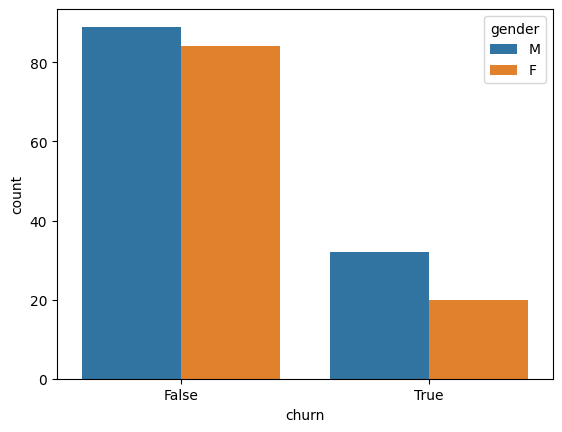

In [18]:
# Create a barplot for churn vs gender
df_pd = df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_pd)
plt.show()

Show the page use distribution between churn and normal users

In [19]:
churn_count = df_withchurn.filter(df_withchurn.churn==1).count()
no_churn_count = df_withchurn.filter(df_withchurn.churn==0).count()

df_temp1 = df_withchurn.filter(df_withchurn.churn==1).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("cFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = df_withchurn.filter(df_withchurn.churn==0).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("ncFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")

<Axes: xlabel='page'>

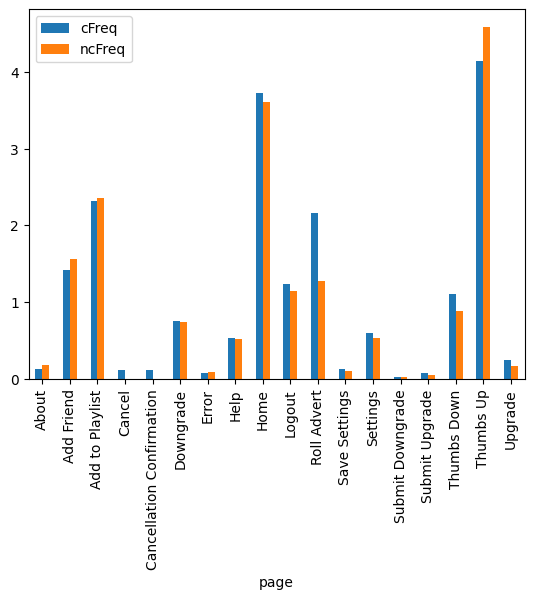

In [20]:
df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.bar("page")

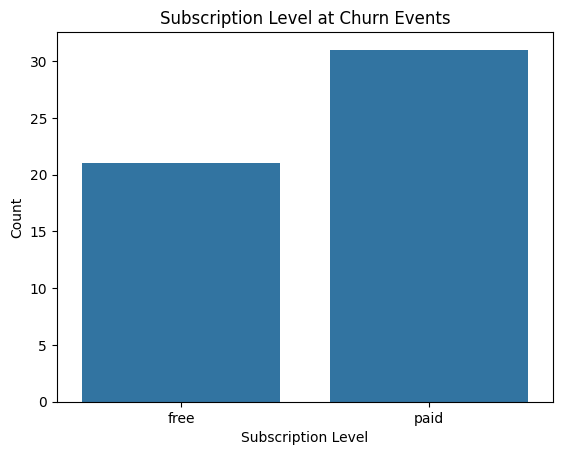

In [21]:
# Show the subscription level at churn events
df_churn_level = df_withchurn.filter(df_withchurn.page == "Cancellation Confirmation").select("userId", "level").dropDuplicates()
df_churn_level_pd = df_churn_level.groupby("level").count().toPandas()
sns.barplot(x='level', y='count', data=df_churn_level_pd)
plt.title("Subscription Level at Churn Events")
plt.xlabel("Subscription Level")
plt.ylabel("Count")
plt.show()

In [22]:
# Show the time span of the log
time_span = df.select(min("ts").alias("start_time"), max("ts").alias("end_time")).collect()
start_time = datetime.datetime.fromtimestamp(time_span[0]['start_time'] / 1000.0).strftime("%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.fromtimestamp(time_span[0]['end_time'] / 1000.0).strftime("%Y-%m-%d %H:%M:%S")
print(f"Time Span of Log: {start_time} to {end_time}")

Time Span of Log: 2018-10-01 04:01:57 to 2018-12-03 05:11:16


<Axes: xlabel='count', ylabel='churn'>

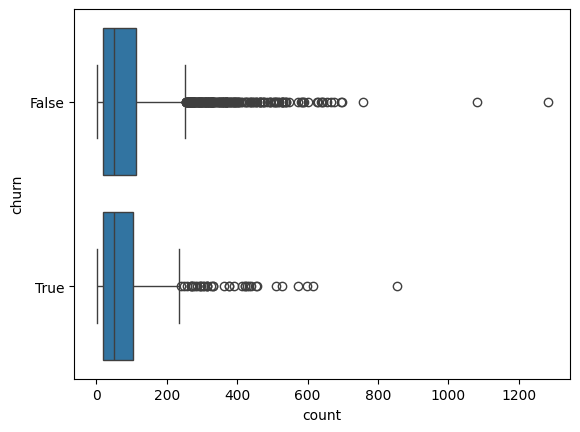

In [23]:
# Show the distribution of operations in each session
df_pd = df_withchurn.groupby("churn", "userId", "sessionId").count().toPandas()
sns.boxplot(x='count', y='churn', orient="h", data=df_pd)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Feature#1: Number of days since registration

In [24]:
user_max_ts = df_withchurn.groupby("userId").max("ts").sort("userId")
user_reg_ts = df_withchurn.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))

In [25]:
user_reg_days.show(10)

+------+------------------+
|userId|            regDay|
+------+------------------+
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
|    15|56.513576388888886|
|   132|  66.8891087962963|
|   101|        53.9659375|
|    11|124.47825231481481|
|   138| 66.62668981481481|
|    29|60.104050925925925|
+------+------------------+
only showing top 10 rows



Feature#2: Avg, min, max, time/session

In [26]:
user_session_time = df_withchurn.groupby("userId", "sessionId").agg(((max(df_withchurn.ts)-min(df_withchurn.ts))/(1000*60)).alias("sessionTime"))
user_session_time_stat = user_session_time.groupby("userId").agg(avg(user_session_time.sessionTime).alias("avgSessionTime"), min(user_session_time.sessionTime).alias("minSessionTime"), max(user_session_time.sessionTime).alias("maxSessionTime")).sort("userId")

In [27]:
user_session_time_stat.show(10)

+------+------------------+-----------------+------------------+
|userId|    avgSessionTime|   minSessionTime|    maxSessionTime|
+------+------------------+-----------------+------------------+
|    10|459.74722222222226|91.41666666666667|1547.9166666666667|
|   100| 316.5190476190476|              0.0|1019.5833333333334|
|100001|148.15833333333333|             63.0|215.28333333333333|
|100002|201.18333333333334|              0.0| 730.4666666666667|
|100003| 99.11666666666667|3.216666666666667|195.01666666666668|
|100004|185.98650793650793|              0.0| 940.2166666666667|
|100005|120.18666666666668|              0.0|209.21666666666667|
|100006| 93.43333333333334|93.43333333333334| 93.43333333333334|
|100007|189.41111111111113|              8.9| 675.6333333333333|
|100008| 528.2527777777779|            57.05|            2024.4|
+------+------------------+-----------------+------------------+
only showing top 10 rows



Feature#3: Number of songs per seesion

In [28]:
user_session_songs = df_withchurn.filter(df_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
user_session_songs_avg = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avgSessionSongs")).sort("userId")
user_session_songs_avg.show(10)

+------+------------------+
|userId|   avgSessionSongs|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|             33.25|
|100002|             48.75|
|100003|              25.5|
|100004|              47.1|
|100005|              38.5|
|100006|              26.0|
|100007|              47.0|
|100008|128.66666666666666|
+------+------------------+
only showing top 10 rows



Feature#4: Number of Sessions

In [29]:
user_session_count = df_withchurn.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
user_session_count = user_session_count.withColumnRenamed("count", "sessionCount")

In [30]:
user_session_count.show(10)

+------+------------+
|userId|sessionCount|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
|     7|           7|
|    15|          15|
|    54|          37|
|   155|           6|
|   132|          16|
+------+------------+
only showing top 10 rows



Feature#5: Gender 

In [31]:
user_gender = df_withchurn.select("userId", "gender").dropDuplicates()
user_gender = user_gender.replace(["M", "F"], ["0", "1"], "gender")
user_gender = user_gender.select("userId", user_gender.gender.cast("int"))

In [32]:
user_gender.show(10)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    39|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   100|     0|
|    25|     1|
+------+------+
only showing top 10 rows



Feature#6: If user still paied?

In [33]:
# Step 1: Group by userId and level to find the latest timestamp for each level
user_paid = df_withchurn.groupby("userId", "level").agg(max(df_withchurn.ts).alias("finalTime")).sort("userId")

# Step 2: Group by userId to find the most recent timestamp overall
user_recent_level_time = user_paid.groupby("userId").agg(max(user_paid.finalTime).alias("recent"))

# Step 3: Join to get the corresponding level for the most recent timestamp
user_recent_level = user_recent_level_time.alias("recent_time") \
    .join(user_paid.alias("paid"), 
          (col("recent_time.userId") == col("paid.userId")) & 
          (col("recent_time.recent") == col("paid.finalTime"))) \
    .select(col("paid.userId"), col("paid.level")).sort("userId")

# Step 4: Replace level strings ("free" -> 0, "paid" -> 1) and cast to integer
user_recent_level = user_recent_level.replace(["free", "paid"], ["0", "1"], "level")
user_recent_level = user_recent_level.select("userId", user_recent_level.level.cast("int"))



In [34]:
# Show the results
user_recent_level.show()

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
|100009|    0|
|100010|    0|
|100011|    0|
|100012|    0|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    0|
|100018|    0|
+------+-----+
only showing top 20 rows



Feature#7: Pages use frequency

In [35]:
# Calculate the total page views for each user
page_list = [(row['page']) for row in df_withchurn.select("page").dropDuplicates().collect()]

# Remove columns that could cause data leakage
page_list.remove("Cancel")
page_list.remove("Cancellation Confirmation")

# Calculate the total pages each user views
user_page_view_count = df_withchurn.groupby("userId").count()
user_page_view_count = user_page_view_count.withColumnRenamed("count", "pageCount")

for page in page_list:
    col_name = "count" + page.replace(" ", "")
    view_count = df_withchurn.filter(df_withchurn.page==page).groupby("userId").count()
    view_count = view_count.withColumnRenamed("count", col_name).withColumnRenamed("userId", "userIdTemp")
    user_page_view_count = user_page_view_count.join(view_count, user_page_view_count.userId==view_count.userIdTemp, "left").drop("userIdTemp")
user_page_view_count = user_page_view_count.sort("userId")
user_page_view_count = user_page_view_count.fillna(0)

In [36]:
# Calculate page view frequencies
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_count.createOrReplaceTempView("user_page_view_count")
user_page_view_freq = spark.sql(freq_sql)

# Display the page view frequencies
user_page_view_freq.show(10)

+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+-------------------+--------------------+-------------------+--------------------+
|userId| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|      freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|
+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+-------------------+--------------------+-------------

Feature#8: Number of singers dose the user listen.

In [37]:
# Calculate artist count per user
user_artist_count = df_withchurn.filter(df_withchurn.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
user_artist_count = user_artist_count.withColumnRenamed("count", "artistCount")

# Display artist count
user_artist_count.show(10)

+------+-----------+
|userId|artistCount|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
|     7|        142|
|    15|       1302|
|    54|       1744|
|   155|        643|
|   132|       1299|
+------+-----------+
only showing top 10 rows



In [38]:
# Add user churn data
# Define churn status for each user
user_churn = df_withchurn.select("userId", "churn").dropDuplicates()
user_churn = user_churn.select("userId", user_churn.churn.cast("int"))

# Display user churn information
user_churn.show(10)


+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|    50|    0|
|    30|    0|
|     8|    0|
|     4|    0|
|    65|    0|
|   101|    1|
|    13|    0|
|    42|    0|
|    94|    0|
+------+-----+
only showing top 10 rows



In [39]:
# put all the features dataframe into a list
features_list = []
features_list.append(user_reg_days)
features_list.append(user_session_time_stat)
features_list.append(user_session_songs_avg)
features_list.append(user_session_count)
features_list.append(user_gender)
features_list.append(user_recent_level)
features_list.append(user_page_view_freq)
features_list.append(user_artist_count)
features_list.append(user_churn)

In [40]:
# prepare the final dataframe to join all the other features
df_final = df_withchurn.select("userId").dropDuplicates()

In [41]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "userIdTemp")
    df = df1.join(df2, df1.userId == df2.userIdTemp, "left").drop("userIdTemp")
    return df

In [42]:
# use function to merge the features in the list
for feature in features_list:
    df_final = features_merge(df_final, feature)

In [43]:
# sort and view the final dataframe
df_final = df_final.sort("userId")
df_final.persist()
df_final.show(10)

+------+------------------+------------------+-----------------+------------------+------------------+------------+------+-----+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+-------------------+--------------------+-------------------+--------------------+-----------+-----+
|userId|            regDay|    avgSessionTime|   minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|level| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|      freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|artistCount|churn|
+------+------------------+-----------

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

1. Prepare the Dataset for Modeling

- We need to combine all features into a single DataFrame for modeling. This includes:

- Joining the features_list DataFrames on userId.
- Converting Spark DataFrame into a feature vector for machine learning.

In [91]:
# Combine all features into a single DataFrame
from functools import reduce

final_features = reduce(lambda left, right: left.join(right, "userId", "outer"), features_list)

# Fill missing values with 0
final_features = final_features.fillna(0)

# Convert features into a feature vector
from pyspark.ml.feature import VectorAssembler

feature_columns = [col for col in final_features.columns if col != "userId" and col != "churn"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
final_features = assembler.transform(final_features)

2. Split the Dataset

- Split the dataset into training, validation, and test sets:

In [92]:
train, test = final_features.randomSplit([0.8, 0.2], seed=42)
train, validation = train.randomSplit([0.75, 0.25], seed=42)

3. Train Machine Learning Models

- Try several machine learning models such as Logistic Regression, Random Forest, and Gradient Boosted Trees.

Train Logic Regression Model

In [93]:

# Initialize Logistic Regression
lr = LogisticRegression(labelCol="churn", featuresCol="features", maxIter=20)

# Train Logistic Regression
lr = LogisticRegression(labelCol="churn", featuresCol="features", maxIter=20)
lr_model = lr.fit(train)

# Evaluate Logistic Regression
lr_predictions = lr_model.transform(validation)
evaluator = MulticlassClassificationEvaluator(labelCol="churn", metricName="f1")
lr_f1_score = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression F1 Score: {lr_f1_score}")

Logistic Regression F1 Score: 0.8742420534573238


4. Compare Models

- Train and evaluate other models

Train Random Fores Model

In [94]:
# RandomFores Classifier

# Random Forest
rf = RandomForestClassifier(labelCol="churn", featuresCol="features", numTrees=100)
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(validation)

# Evaluate Random Forest
rf_f1_score = evaluator.evaluate(rf_predictions)
print(f"Random Forest F1 Score: {rf_f1_score}")

Random Forest F1 Score: 0.7914053426248548


Train Gradient Boosted Trees Model

In [95]:
# Gradient Boosted Trees
gbt = GBTClassifier(labelCol="churn", featuresCol="features", maxIter=50)
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(validation)

# Evaluate Gradient Boosted Trees
gbt_f1_score = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosted Trees F1 Score: {gbt_f1_score}")

Gradient Boosted Trees F1 Score: 0.7563624508425536


Train Decision Tree

In [96]:
# Decision Tree
dt = DecisionTreeClassifier(labelCol="churn", featuresCol="features", maxDepth=10)
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(validation)

# Evaluate Decision Tree
dt_f1_score = evaluator.evaluate(dt_predictions)
print(f"Decision Tree F1 Score: {dt_f1_score}")

Decision Tree F1 Score: 0.7035868005738881


Train Naive Bayes Model

In [97]:

# Naive Bayes
nb = NaiveBayes(labelCol="churn", featuresCol="features", smoothing=1.0)
nb_model = nb.fit(train)
nb_predictions = nb_model.transform(validation)

# Evaluate Naive Bayes
nb_f1_score = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes F1 Score: {nb_f1_score}")


Naive Bayes F1 Score: 0.4700212407529481


Choose the Best Model

To choose the best model, we need to compare the F1 scores of all the models trained.

Collect F1 Scores

In [100]:
# Assuming these F1 scores are calculated for the validation set
model_scores = {
    "Logistic Regression": lr_f1_score,
    "Random Forest": rf_f1_score,
    "Gradient Boosted Trees": gbt_f1_score,
    "Decision Tree": dt_f1_score,
    "Naive Bayes": nb_f1_score
}

# Print the scores for comparison
for model, score in model_scores.items():
    print(f"{model}: F1 Score = {score}")

Logistic Regression: F1 Score = 0.8742420534573238
Random Forest: F1 Score = 0.7914053426248548
Gradient Boosted Trees: F1 Score = 0.7563624508425536
Decision Tree: F1 Score = 0.7035868005738881
Naive Bayes: F1 Score = 0.4700212407529481


Best Model: Logistic Regression

- With the highest F1 Score of 0.874, Logistic Regression is the best-performing model on the validation set.

- To confirm its performance, evaluate the Logistic Regression model on the test set

In [103]:
# Final evaluation on the test set
lr_test_predictions = lr_model.transform(test)

# Evaluate F1 Score on the test set
final_f1_score = evaluator.evaluate(lr_test_predictions)
print(f"Final F1 Score on Test Set for Logistic Regression: {final_f1_score}")

Final F1 Score on Test Set for Logistic Regression: 0.9125733312192802


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.